# Exploratory data analysis

In [1]:
# load json
import json
with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/voc_all.json') as f:
    all_data=json.load(f)
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/train_new.json') as g:
#     train=json.load(g)  
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/val_new.json') as h:
#     val=json.load(h)

In [2]:
print('number category: {}'.format(len(all_data['categories'])))
all_data['categories']

number category: 4


[{'name': 'holothurian', 'id': 1},
 {'name': 'echinus', 'id': 2},
 {'name': 'scallop', 'id': 3},
 {'name': 'starfish', 'id': 4}]

In [3]:
print('训练图片数量: {}'.format(len(all_data['images'])))
print('训练标签数量: {}'.format(len(all_data['annotations'])))

训练图片数量: 5543
训练标签数量: 41441


In [4]:
total=[]
for img in all_data['images']:
    wh=(img['width'], img['height'])
    total.append(wh)
unique=set(total)
for k in unique:
    print('长宽为({}, {})的数量: {}'.format(k[0], k[1], total.count(k)))

长宽为(704, 576)的数量: 38
长宽为(1920, 1080)的数量: 596
长宽为(3840, 2160)的数量: 1712
长宽为(720, 405)的数量: 3153
长宽为(586, 480)的数量: 44


In [5]:
anns_id = []
images_id = []
for anns in all_data['annotations']:
    anns_id.append(anns['id'])
    images_id.append(anns['image_id'])
print('训练集图片数量: ', len(all_data['images']))
print('unique id 数量: ', len(set(anns_id)))
print('unique image_id 数量: ', len(set(images_id)))

训练集图片数量:  5543
unique id 数量:  41441
unique image_id 数量:  5455


**训练图片的id数量与标注对应的图片数量不匹配**，意味着可能存在标注错误或者图片缺失，因此需要对annos作进一步过滤

### 查看缺失图片数量

In [6]:
import os
unique_image = {'{:06d}'.format(img_id) for img_id in set(images_id)}
actual_images_names = os.listdir('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/image')
actual_images_id = [img_name.split('.')[0] for img_name in actual_images_names]
origin_list = set(actual_images_id)

gaps = origin_list - unique_image
print('缺少标注的图像数量：{}'.format(len(gaps)))


缺少标注的图像数量：88


gaps的元素在origin_list中存在，但是在unique_image中不存在,有88个文件没有标注信息，annotation为空那么在训练的过程中，全图为空，没有标注的图，应该删掉，或者使用mixup，增强特征

mmdetection会自动删除全图标注为空的样本

### 查看统计量

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [8]:
## 创建类别标签字典
category_dict = dict([(cate['id'], cate['name']) for cate in all_data['categories']])
category_dict

{1: 'holothurian', 2: 'echinus', 3: 'scallop', 4: 'starfish'}

In [9]:
counts_label_all=dict([(cate['name'], 0) for cate in all_data['categories']])
# counts_label_train=dict([(j['name'], 0) for j in train['categories']])
# counts_label_val=dict([(h['name'], 0) for h in val['categories']])
for anns in all_data['annotations']:
    counts_label_all[category_dict[anns['category_id']]] += 1
# for j in train['annotations']:  
#     counts_label_train[category_dic[j['category_id']]] += 1
# for n in val['annotations']:
#     counts_label_val[category_dic[n['category_id']]] += 1
    
print("总数据集每个类别的标注数量： {}".format(counts_label_all))
# print("train集每个类别的标注数量： {}".format(counts_label_train))
# print("val集每个类别的标注数量： {}".format(counts_label_val))

总数据集每个类别的标注数量： {'holothurian': 5537, 'echinus': 22343, 'scallop': 6720, 'starfish': 6841}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


                 0
holothurian   5537
echinus      22343
scallop       6720
starfish      6841


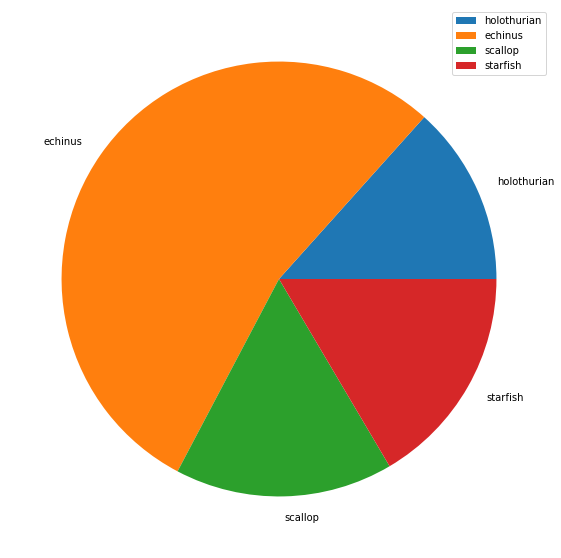

In [10]:
# 打印
%matplotlib inline 
plt.style.use({'figure.figsize':(10, 10)})
indices=counts_label_all.keys()
values=counts_label_all.values()
count_df=pd.DataFrame(list(values),index=indices)
print(count_df)
count_df.iloc[:,0].plot.pie()
plt.legend()
plt.axis('off')
plt.show()

<AxesSubplot:>

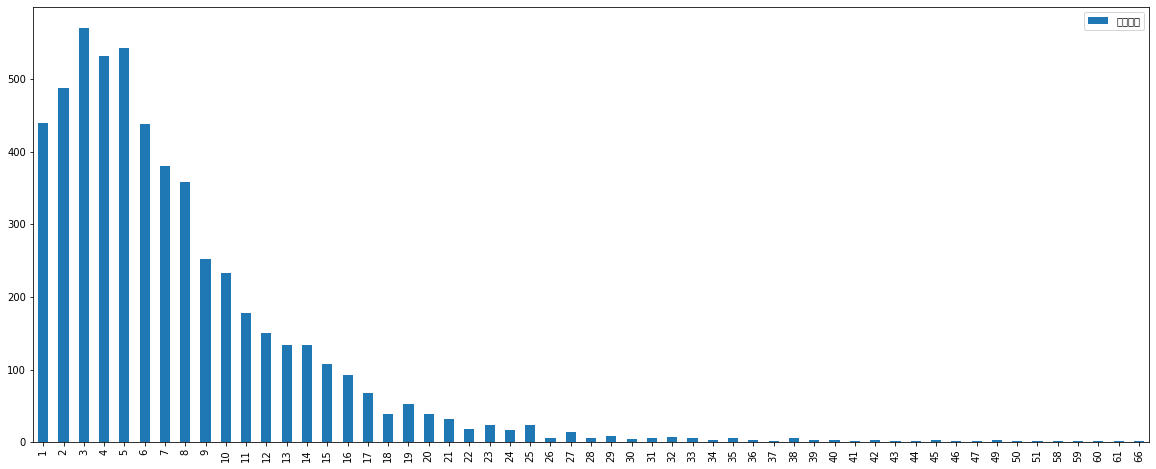

In [12]:
# 存在相同标签数量的图的数量的统计直方图
%matplotlib inline
plt.style.use({'figure.figsize':(20, 8)})
annoto_count={}
for i in all_data['annotations']:
    annoto_count[i['image_id']]=annoto_count.setdefault(i['image_id'],0)+1
indes_list=set(annoto_count.values())
values_count=[list(annoto_count.values()).count(i) for i in indes_list]
pd.DataFrame(values_count,index=indes_list,columns=['标签数量']).plot(kind='bar')
# 有1个标注的图的数量有440张
# 有3个标注的图的数量有580张

In [13]:
# 剔除冗余信息
anntotations =[]
for i in all_data['annotations']:
    an=i
    an.pop('id')  # anns的标注id
    an.pop('iscrowd')
    anntotations.append(an)

In [14]:
# 将标签于对应图片合并起来，形成新的数据格式
data = []
per_sample = {}
for img in all_data['images']:
    sample_img = img
    annota_list = [] # 保存该图片对应的标签
    for per in anntotations:
        if per['image_id']==img['id']:   # 将一张图的所有的ann装进annota_list中
            annota_list.append(per)
    for k in annota_list:
        anntotations.remove(k)   # 把拿出来的ann在总的标注文件中都删除掉
    sample_img['annotations'] = annota_list
    data.append(sample_img)

宽高比1.0: 数量:34075
宽高比2.0: 数量:6568
宽高比3.0: 数量:705
宽高比4.0: 数量:75
宽高比5.0: 数量:12
宽高比6.0: 数量:2
宽高比7.0: 数量:3
宽高比21.0: 数量:1


/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 23485 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/alex/anaconda3/envs/pytorch/

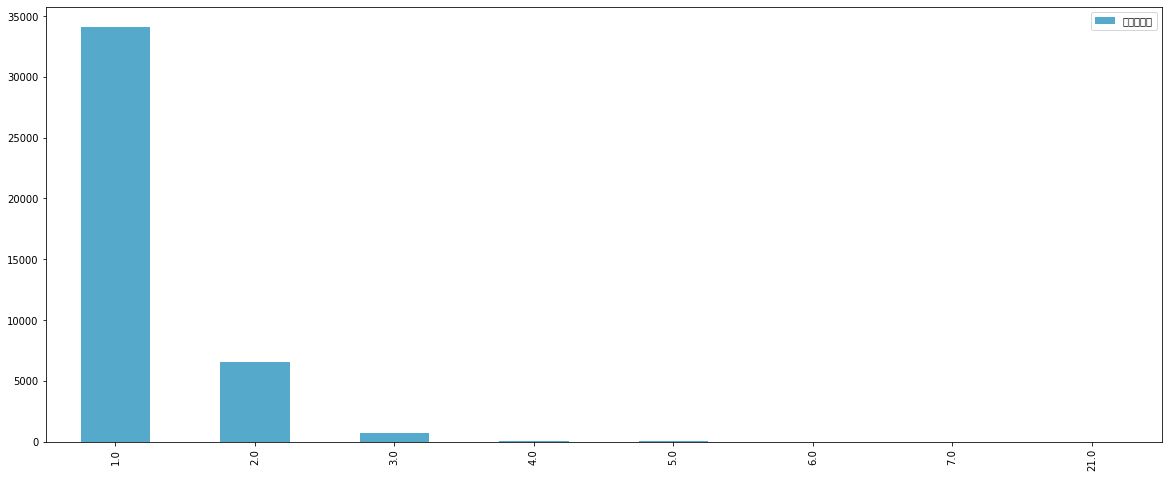

In [15]:
# 对所有标注长宽做统计
total_size=[]
total_height=[]
total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        # total_width += [b['bbox'][2]]
        # total_height += [b['bbox'][3]]
        wh = round(b['bbox'][2]/b['bbox'][3], 0)
        if wh < 1 :
            wh = round(b['bbox'][3]/b['bbox'][2],0)
        total_wh += [wh]

# 所有标签的长宽高比例
box_wh_unique = list(set(total_wh))
box_wh_count=[total_wh.count(i) for i in box_wh_unique]

bbox_wh_dict = {}
for i, key in enumerate(box_wh_unique):
    print('宽高比{}: 数量:{}'.format(key, box_wh_count[i]))

# 绘图
wh_df = pd.DataFrame(box_wh_count,index=box_wh_unique,columns=['宽高比数量'])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()

<AxesSubplot:>

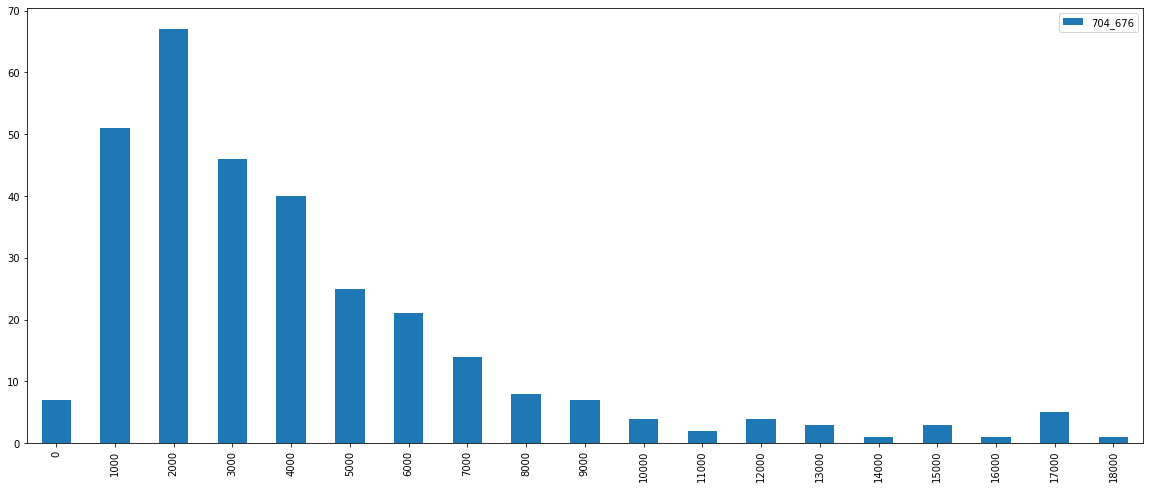

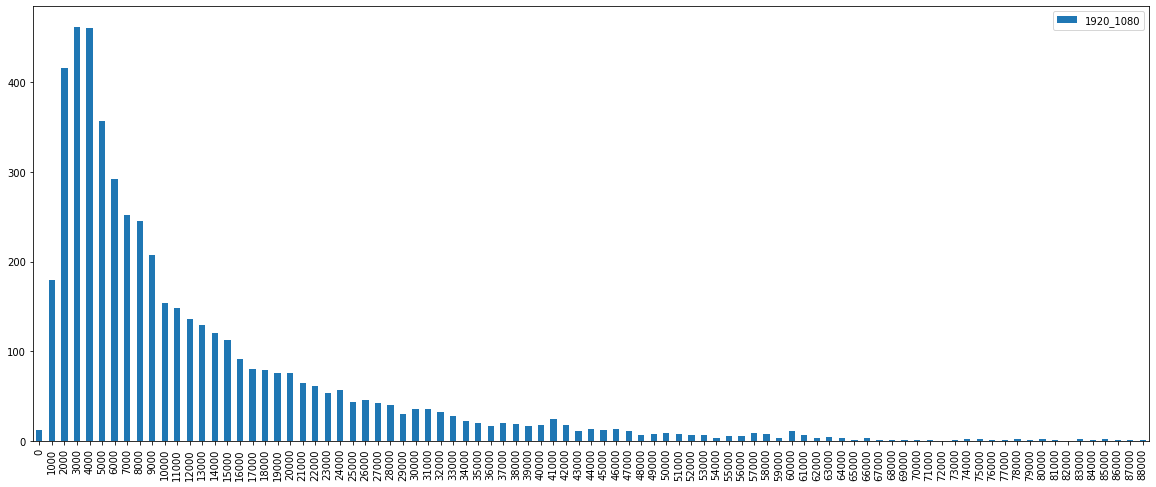

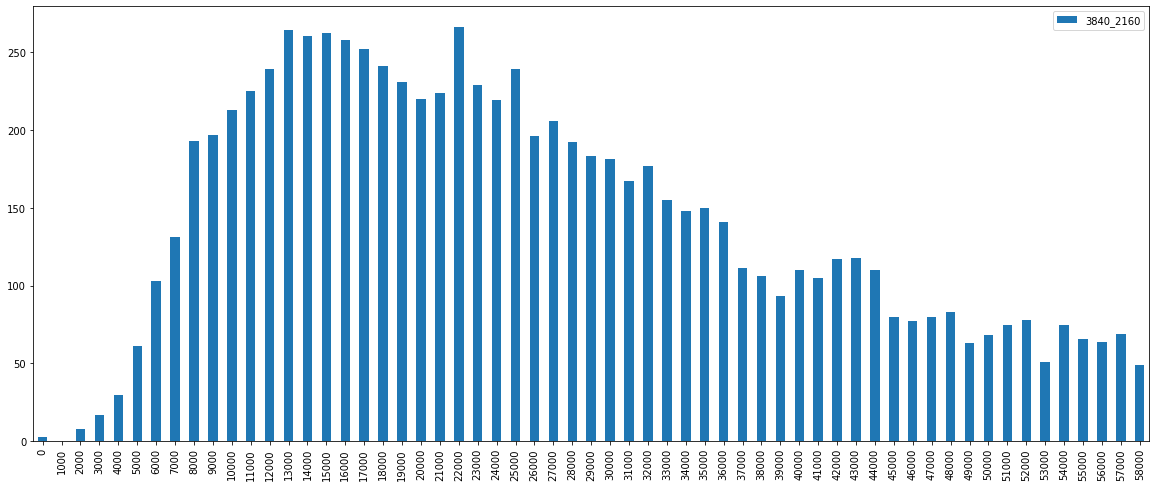

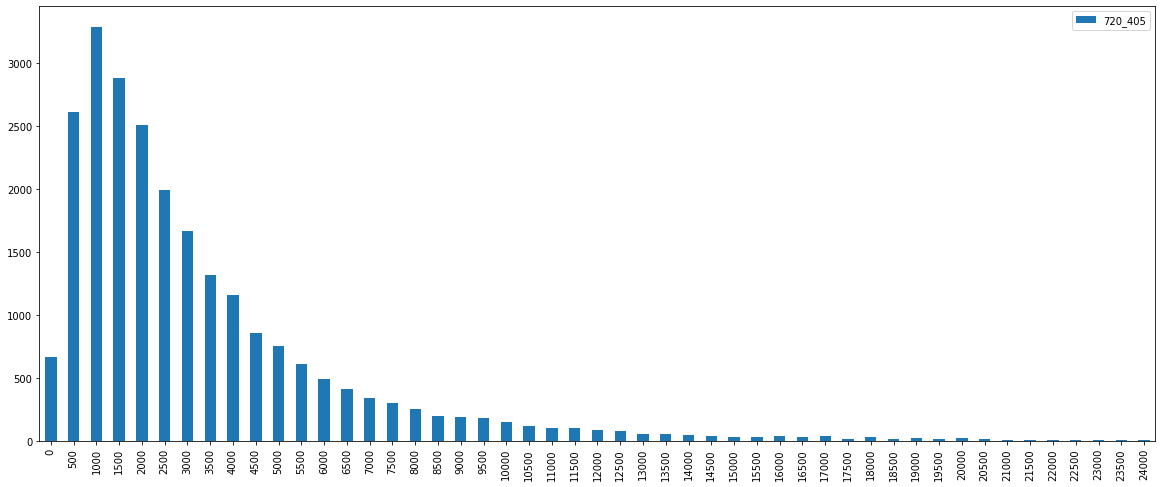

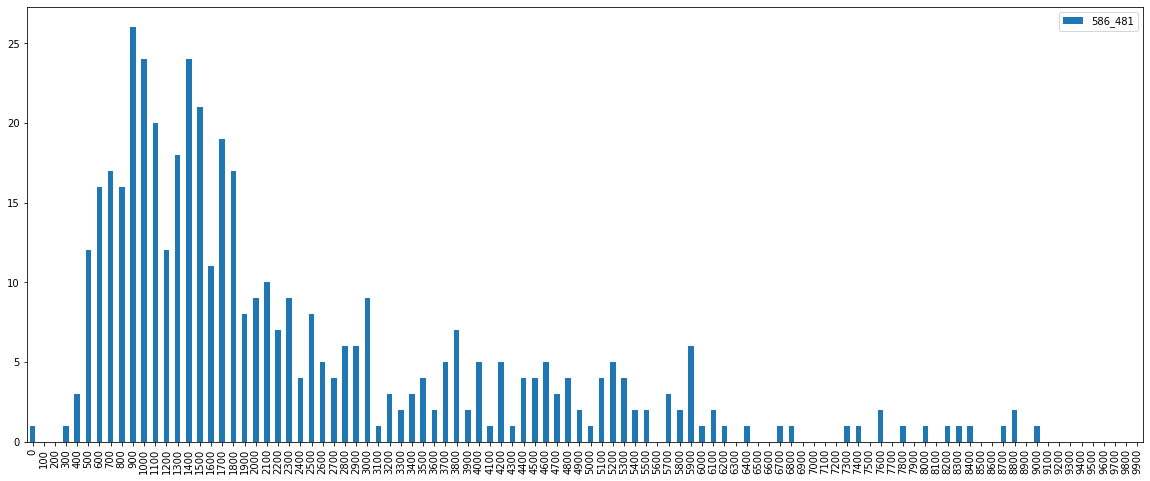

In [16]:
# 对所有标注面积比做统计
total_size704_676=[]
total_size1920_1080=[]
total_size3840_2160=[]
total_size720_405=[]
total_size586_481=[]

total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        if (im['width'], im['height']) == list(unique)[0]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size704_676 += [size]
        elif (im['width'], im['height']) == list(unique)[1]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size1920_1080 += [size]
        elif (im['width'], im['height']) == list(unique)[2]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size3840_2160 += [size]
        elif (im['width'], im['height']) == list(unique)[3]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size720_405 += [size]
        elif (im['width'], im['height']) == list(unique)[4]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size586_481 += [size]


max_size = max(total_size704_676)
gap = 1000
group_names = list(range(0,20000,gap))
size_cuts = pd.cut(total_size704_676,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'704_676':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size1920_1080)
gap = 1000
group_names = list(range(0,90000,gap))
size_cuts = pd.cut(total_size1920_1080,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'1920_1080':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size3840_2160)
gap = 1000
group_names = list(range(0,60000,gap))
size_cuts = pd.cut(total_size3840_2160,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'3840_2160':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size720_405)
gap = 500
group_names = list(range(0,25000,gap))
size_cuts = pd.cut(total_size720_405,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'720_405':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size586_481)
gap = 100
group_names = list(range(0,max_size,gap))
size_cuts = pd.cut(total_size586_481,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'586_481':size_cuts.value_counts()})
total_df.plot(kind='bar')